# Capstone Project: Finding the best venue to open a pizza restaurant in NYC

<h2> Note: This notebook is used mainly for the capstone project on coursera's IBM Data Science Professional Certification </h2>
<h2> Another Note: Stay safe everyone! Stay at home, eat healthy and learn admidst this crisis </h2>

![alt text](https://m.economictimes.com/thumb/msid-71427663,width-400,height-300,resizemode-4,imgsize-57628/coursera-agencies.jpg "Apple and Green Paper")

<strong> Importing the necessary libraries </strong>

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

# For downloading datasets
import types
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0
print('Libraries imported.')

Libraries imported.


<strong> This cell contains foursquare API credentials and has been removed for sharing </strong>

In [2]:
# The code was removed by Watson Studio for sharing.

# Part 1:Loading the datasets

<h3> First Dataset: Latitutude and longitude coordinates of each neighborhood in New York </h3>

<strong> Downloading the dataset that contains the 5 boroughs and 306 neighborhoods that exist in each borough as well as the the latitude and logitude coordinates of each neighborhood </strong>

In [3]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


<strong> Loading the data and extracing useful information </strong>

In [4]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
    
neighborhoods_data = newyork_data['features']

<strong> Tranform the data into a pandas dataframe </strong>

In [5]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

# Looping and filling te dataframe one row at a time
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)


<strong> Examine the resulting dataframe </strong>

In [6]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


<strong> Making sure that the dataset has all 5 boroughs and 306 neighborhoods </strong>

In [7]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


<h3> Second Dataset: Crime data on each borough and neighbourhood in New York </h3>

<strong> Downloading the crime dataset from IBM Cloud (Cell Removed due to authentication information inside) </strong>

In [8]:
# The code was removed by Watson Studio for sharing.

<strong> Loading the dataset and reading the first 5 rows </strong>

In [9]:
df_crime = pd.read_csv(body)
df_crime.head()

,CMPLNT_NUM,ADDR_PCT_CD,BORO_NM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,CRM_ATPT_CPTD_CD,HADEVELOPT,HOUSING_PSA,JURISDICTION_CODE,JURIS_DESC,KY_CD,LAW_CAT_CD,LOC_OF_OCCUR_DESC,OFNS_DESC,PARKS_NM,PATROL_BORO,PD_CD,PD_DESC,PREM_TYP_DESC,RPT_DT,STATION_NAME,SUSP_AGE_GROUP,SUSP_RACE,SUSP_SEX,TRANSIT_DISTRICT,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lat_Lon
0,314773184,48,BRONX,12/31/2019,18:00:00,NaN,NaN,COMPLETED,NaN,NaN,0.0,N.Y. POLICE DEPT,105,FELONY,NaN,ROBBERY,NaN,PATROL BORO BRONX,386.0,"ROBBERY,PERSONAL ELECTRONIC DEVICE",STREET,12/31/2019,NaN,UNKNOWN,UNKNOWN,U,NaN,45-64,WHITE HISPANIC,F,1016990,244612,40.838026,-73.881681,"(40.838026269000075, -73.88168118799997)"
1,289837961,25,MANHATTAN,12/30/2019,20:30:00,12/31/2019,10:00:00,COMPLETED,NaN,NaN,0.0,N.Y. POLICE DEPT,341,MISDEMEANOR,INSIDE,PETIT LARCENY,NaN,PATROL BORO MAN NORTH,338.0,"LARCENY,PETIT FROM BUILDING,UN",RESIDENCE - APT. HOUSE,12/31/2019,NaN,NaN,NaN,NaN,NaN,25-44,WHITE HISPANIC,F,999296,230862,40.800334,-73.945657,"(40.800334261000046, -73.94565697199994)"
2,535744284,77,BROOKLYN,12/24/2019,16:55:00,12/24/2019,17:00:00,COMPLETED,NaN,NaN,0.0,N.Y. POLICE DEPT,106,FELONY,NaN,FELONY ASSAULT,NaN,PATROL BORO BKLYN NORTH,109.0,"ASSAULT 2,1,UNCLASSIFIED",STREET,12/31/2019,NaN,UNKNOWN,BLACK,M,NaN,18-24,WHITE,M,1001068,183317,40.669832,-73.939376,"(40.66983179600004, -73.93937555099996)"
3,895678119,52,BRONX,12/30/2019,19:32:00,NaN,NaN,COMPLETED,NaN,NaN,0.0,N.Y. POLICE DEPT,341,MISDEMEANOR,INSIDE,PETIT LARCENY,NaN,PATROL BORO BRONX,333.0,"LARCENY,PETIT FROM STORE-SHOPL",CHAIN STORE,12/30/2019,NaN,25-44,WHITE,F,NaN,UNKNOWN,UNKNOWN,D,1009690,257590,40.873671,-73.908014,"(40.87367103500002, -73.90801364899994)"
4,299841674,18,MANHATTAN,12/30/2019,15:30:00,12/30/2019,16:50:00,COMPLETED,NaN,NaN,0.0,N.Y. POLICE DEPT,341,MISDEMEANOR,NaN,PETIT LARCENY,NaN,PATROL BORO MAN SOUTH,301.0,"LARCENY,PETIT BY ACQUIRING LOS",STREET,12/30/2019,NaN,NaN,NaN,NaN,NaN,25-44,WHITE HISPANIC,M,985766,216503,40.760935,-73.994529,"(40.76093528000007, -73.99452906599998)"


<strong> Creating a new dataframe "crime_analysis" with relevant information used for data analysis </strong>

In [10]:
crime_analysis =df_crime.drop(['CMPLNT_FR_TM','CMPLNT_TO_DT','CMPLNT_TO_TM','HADEVELOPT','HOUSING_PSA','LOC_OF_OCCUR_DESC','PARKS_NM','STATION_NAME','SUSP_AGE_GROUP','SUSP_RACE','SUSP_RACE','SUSP_SEX','TRANSIT_DISTRICT','VIC_AGE_GROUP','VIC_RACE','VIC_SEX','X_COORD_CD','Y_COORD_CD','Lat_Lon'], axis=1)
crime_analysis.head()

,CMPLNT_NUM,ADDR_PCT_CD,BORO_NM,CMPLNT_FR_DT,CRM_ATPT_CPTD_CD,JURISDICTION_CODE,JURIS_DESC,KY_CD,LAW_CAT_CD,OFNS_DESC,PATROL_BORO,PD_CD,PD_DESC,PREM_TYP_DESC,RPT_DT,Latitude,Longitude
0,314773184,48,BRONX,12/31/2019,COMPLETED,0.0,N.Y. POLICE DEPT,105,FELONY,ROBBERY,PATROL BORO BRONX,386.0,"ROBBERY,PERSONAL ELECTRONIC DEVICE",STREET,12/31/2019,40.838026,-73.881681
1,289837961,25,MANHATTAN,12/30/2019,COMPLETED,0.0,N.Y. POLICE DEPT,341,MISDEMEANOR,PETIT LARCENY,PATROL BORO MAN NORTH,338.0,"LARCENY,PETIT FROM BUILDING,UN",RESIDENCE - APT. HOUSE,12/31/2019,40.800334,-73.945657
2,535744284,77,BROOKLYN,12/24/2019,COMPLETED,0.0,N.Y. POLICE DEPT,106,FELONY,FELONY ASSAULT,PATROL BORO BKLYN NORTH,109.0,"ASSAULT 2,1,UNCLASSIFIED",STREET,12/31/2019,40.669832,-73.939376
3,895678119,52,BRONX,12/30/2019,COMPLETED,0.0,N.Y. POLICE DEPT,341,MISDEMEANOR,PETIT LARCENY,PATROL BORO BRONX,333.0,"LARCENY,PETIT FROM STORE-SHOPL",CHAIN STORE,12/30/2019,40.873671,-73.908014
4,299841674,18,MANHATTAN,12/30/2019,COMPLETED,0.0,N.Y. POLICE DEPT,341,MISDEMEANOR,PETIT LARCENY,PATROL BORO MAN SOUTH,301.0,"LARCENY,PETIT BY ACQUIRING LOS",STREET,12/30/2019,40.760935,-73.994529


<strong> Convert Borough names into which only the first letter of the Borough names is an upper case  </strong>

In [11]:
crime_analysis['BORO_NM'] = crime_analysis['BORO_NM'].str.title() 
crime_analysis.head()

,CMPLNT_NUM,ADDR_PCT_CD,BORO_NM,CMPLNT_FR_DT,CRM_ATPT_CPTD_CD,JURISDICTION_CODE,JURIS_DESC,KY_CD,LAW_CAT_CD,OFNS_DESC,PATROL_BORO,PD_CD,PD_DESC,PREM_TYP_DESC,RPT_DT,Latitude,Longitude
0,314773184,48,Bronx,12/31/2019,COMPLETED,0.0,N.Y. POLICE DEPT,105,FELONY,ROBBERY,PATROL BORO BRONX,386.0,"ROBBERY,PERSONAL ELECTRONIC DEVICE",STREET,12/31/2019,40.838026,-73.881681
1,289837961,25,Manhattan,12/30/2019,COMPLETED,0.0,N.Y. POLICE DEPT,341,MISDEMEANOR,PETIT LARCENY,PATROL BORO MAN NORTH,338.0,"LARCENY,PETIT FROM BUILDING,UN",RESIDENCE - APT. HOUSE,12/31/2019,40.800334,-73.945657
2,535744284,77,Brooklyn,12/24/2019,COMPLETED,0.0,N.Y. POLICE DEPT,106,FELONY,FELONY ASSAULT,PATROL BORO BKLYN NORTH,109.0,"ASSAULT 2,1,UNCLASSIFIED",STREET,12/31/2019,40.669832,-73.939376
3,895678119,52,Bronx,12/30/2019,COMPLETED,0.0,N.Y. POLICE DEPT,341,MISDEMEANOR,PETIT LARCENY,PATROL BORO BRONX,333.0,"LARCENY,PETIT FROM STORE-SHOPL",CHAIN STORE,12/30/2019,40.873671,-73.908014
4,299841674,18,Manhattan,12/30/2019,COMPLETED,0.0,N.Y. POLICE DEPT,341,MISDEMEANOR,PETIT LARCENY,PATROL BORO MAN SOUTH,301.0,"LARCENY,PETIT BY ACQUIRING LOS",STREET,12/30/2019,40.760935,-73.994529


<h3> Third Dataset: Population in each borough and neighborhood </h3>

<strong> Downloading the population dataset (Cell Removed due to authentication information inside) </strong>

In [12]:
# The code was removed by Watson Studio for sharing.

<strong> Loading and viewing the dataset  </strong>

In [13]:
df_population = pd.read_csv(body)
df_population.head()

,Borough,Year,FIPS County Code,NTA Code,NTA Name,Population
0,Bronx,2000,5,BX01,Claremont-Bathgate,"28,149"
1,Bronx,2000,5,BX03,Eastchester-Edenwald-Baychester,"35,422"
2,Bronx,2000,5,BX05,Bedford Park-Fordham North,"55,329"
3,Bronx,2000,5,BX06,Belmont,"25,967"
4,Bronx,2000,5,BX07,Bronxdale,"34,309"


<strong> Creating a new dataframe "population_analysis" with relevant information used for data analysis </strong>

In [14]:
population_analysis =df_population.drop(['FIPS County Code', 'Year','NTA Code','NTA Name'], axis=1)
population_analysis.head()

,Borough,Population
0,Bronx,"28,149"
1,Bronx,"35,422"
2,Bronx,"55,329"
3,Bronx,"25,967"
4,Bronx,"34,309"


<strong> Removing the comma from the population numbers in the population column and setting the number in the population column as type integer </strong>

In [15]:
population_analysis['Population'] = population_analysis['Population'].str.replace(',', '')
population_analysis['Population'] = population_analysis['Population'].astype(int)
population_analysis.head()

,Borough,Population
0,Bronx,28149
1,Bronx,35422
2,Bronx,55329
3,Bronx,25967
4,Bronx,34309


# Part 2: Choosing the borough for the pizza restaurant to be opened at

### First criteria: Using the Crime Dataset, evaluate which borough has the least crime?

<strong> Counting the total number of crimes that belongs to a certain borough using "values_counts" </strong>

In [16]:
BoroughCountCrime= crime_analysis['BORO_NM'].value_counts(normalize=False, sort=True, ascending=True)
BoroughCountCrime

Staten Island     19019
Queens            92575
Bronx            100994
Manhattan        116352
Brooklyn         132445
Name: BORO_NM, dtype: int64

<strong> We can also view this in relative frequencies by setting normalize=True</strong>

In [17]:
BoroughCountCrimePercent = crime_analysis['BORO_NM'].value_counts(normalize=True, sort=True, ascending=True)
BoroughCountCrimePercent

Staten Island    0.041222
Queens           0.200646
Bronx            0.218893
Manhattan        0.252180
Brooklyn         0.287060
Name: BORO_NM, dtype: float64

<strong> However, we will just use "BoroughCountCrime" that contains the total number of crimes and Convert "BoroughCountCrime" into a dataframe </strong>

In [18]:
BoroughCountCrime = pd.DataFrame(data=BoroughCountCrime)
BoroughCountCrime

,BORO_NM
Staten Island,19019
Queens,92575
Bronx,100994
Manhattan,116352
Brooklyn,132445


In [19]:
# Reset index and rename the columns
BoroughCountCrime = BoroughCountCrime.reset_index()
BoroughCountCrime.columns = ['Borough','Total Count']
BoroughCountCrime

,Borough,Total Count
0,Staten Island,19019
1,Queens,92575
2,Bronx,100994
3,Manhattan,116352
4,Brooklyn,132445


<strong> Plotting a simple bar chart to visualize the total count of crime </strong>

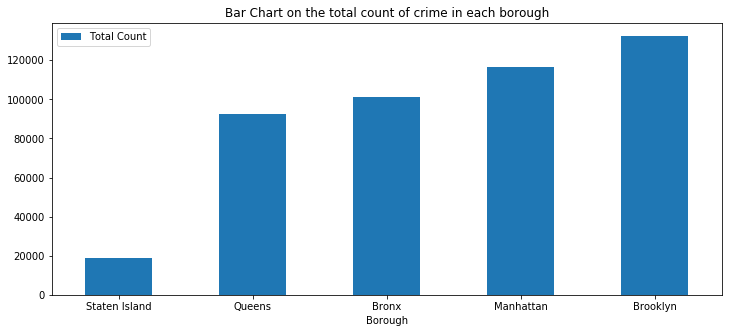

In [61]:
CrimeBar = BoroughCountCrime.plot.bar(x='Borough', y='Total Count', rot=0, title='Bar Chart on the total count of crime in each borough', figsize=(12,5))
CrimeBar

### Second criteria: Using the population data, which has the highest population?

<strong> We total up the population data on the population column based on the Borough using the "groupby" method </strong>

In [21]:
population_analysis_grouped = population_analysis.groupby(['Borough'],as_index=False,sort=True).sum()
population_analysis_grouped

,Borough,Population
0,Bronx,2717758
1,Brooklyn,4970026
2,Manhattan,3123068
3,Queens,4460101
4,Staten Island,912458


<strong> Plotting a simple pie chart on % of population in each borough relative to the whole population of New York City </strong>

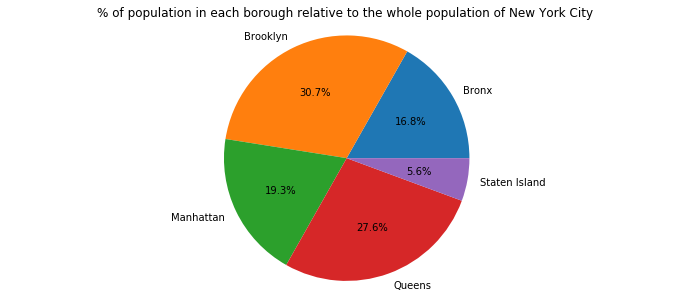

In [22]:
import matplotlib.pyplot as plt
plt.pie(population_analysis_grouped['Population'],labels=population_analysis_grouped['Borough'],autopct='%1.1f%%')
plt.title('% of population in each borough relative to the whole population of New York City')
plt.axis('equal')
fig = plt.gcf()
fig.set_size_inches(12,5)
plt.show()

### Deciding the borough

<strong> Using the above analysis, We will create an evaluation table. We will give a score from 1 to 5 to the boroughs, depending on their performance from both of the criterias above. 5 is given to borough with the lowest crime rate or the highest population number and vice versa. More details is in the report.    </strong>

In [23]:
Borough= ['Bronx', 'Brooklyn', 'Manhattan','Queens','Staten Island']
Rating_Population= [2, 5, 3, 4, 1]
Rating_Crime = [3, 1, 2, 4, 5]

data = {'Borough':Borough, 'Population_score':Rating_Population, 'Crime_score':Rating_Crime}
Evaluation_Table = pd.DataFrame(data) 
Evaluation_Table

,Borough,Population_score,Crime_score
0,Bronx,2,3
1,Brooklyn,5,1
2,Manhattan,3,2
3,Queens,4,4
4,Staten Island,1,5


<strong> Adding up the population score and crime score to derive the total score and creating a column for it. </strong>

In [24]:
Evaluation_Table ["Total"] = Evaluation_Table.sum(axis=1)
Evaluation_Table

,Borough,Population_score,Crime_score,Total
0,Bronx,2,3,5
1,Brooklyn,5,1,6
2,Manhattan,3,2,5
3,Queens,4,4,8
4,Staten Island,1,5,6


<strong> Conclusion: Based on the above analysis, I will choose the borough Queens to be the borough where I will want to open my restaurant in, as it has the highest score. </strong>

## Part 3: Choosing the neighbourhood for the pizza restaurant to be opened at

<strong> Finding the geograpical coordinate of New York City </strong>

In [25]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


<strong> Create a map of New York with neighborhoods superimposed on top </strong>

In [26]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

Note: click on each circle mark to reveal the name of the neighborhood and its respective borough

### First criteria: The number of venues returned by Foursquare API 

<strong> Create a new dataframe of the neighborhoods on Queens from the first dataset </strong>

In [27]:
Queens_data = neighborhoods[neighborhoods['Borough'] == 'Queens'].reset_index(drop=True)
Queens_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Queens,Astoria,40.768509,-73.915654
1,Queens,Woodside,40.746349,-73.901842
2,Queens,Jackson Heights,40.751981,-73.882821
3,Queens,Elmhurst,40.744049,-73.881656
4,Queens,Howard Beach,40.654225,-73.838138


<strong> Get the geographical coordinates of Queens </strong>

In [28]:
Address = 'Queens, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Queens are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Queens are 40.7127281, -74.0060152.


<strong> Create map of Queens using latitude and longitude values with neighborhoods of Queens imposed on it </strong>

In [29]:
# create map of Queens using latitude and longitude values
map_queens = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(Queens_data['Latitude'], Queens_data['Longitude'], Queens_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_queens)  
    
map_queens

<strong> Exploring the venues near the neighborhoods within 500 meters, limit the result returned to be 100 </strong>

In [30]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

#create a function that explore venues near the neighborhoods
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Queens_venues = getNearbyVenues(names=Queens_data['Neighborhood'],
                                   latitudes=Queens_data['Latitude'],
                                   longitudes=Queens_data['Longitude']
                                  )

Astoria
Woodside
Jackson Heights
Elmhurst
Howard Beach
Corona
Forest Hills
Kew Gardens
Richmond Hill
Flushing
Long Island City
Sunnyside
East Elmhurst
Maspeth
Ridgewood
Glendale
Rego Park
Woodhaven
Ozone Park
South Ozone Park
College Point
Whitestone
Bayside
Auburndale
Little Neck
Douglaston
Glen Oaks
Bellerose
Kew Gardens Hills
Fresh Meadows
Briarwood
Jamaica Center
Oakland Gardens
Queens Village
Hollis
South Jamaica
St. Albans
Rochdale
Springfield Gardens
Cambria Heights
Rosedale
Far Rockaway
Broad Channel
Breezy Point
Steinway
Beechhurst
Bay Terrace
Edgemere
Arverne
Rockaway Beach
Neponsit
Murray Hill
Floral Park
Holliswood
Jamaica Estates
Queensboro Hill
Hillcrest
Ravenswood
Lindenwood
Laurelton
Lefrak City
Belle Harbor
Rockaway Park
Somerville
Brookville
Bellaire
North Corona
Forest Hills Gardens
Jamaica Hills
Utopia
Pomonok
Astoria Heights
Hunters Point
Sunnyside Gardens
Blissville
Roxbury
Middle Village
Malba
Hammels
Bayswater
Queensbridge


<strong> Checking the size and first 10 rows of the resulting dataframe </strong>

In [31]:
print(Queens_venues.shape)
Queens_venues.head(10)

(2072, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Astoria,40.768509,-73.915654,Favela Grill,40.767348,-73.917897,Brazilian Restaurant
1,Astoria,40.768509,-73.915654,Orange Blossom,40.769856,-73.917012,Gourmet Shop
2,Astoria,40.768509,-73.915654,Titan Foods Inc.,40.769198,-73.919253,Gourmet Shop
3,Astoria,40.768509,-73.915654,CrossFit Queens,40.769404,-73.918977,Gym
4,Astoria,40.768509,-73.915654,Simply Fit Astoria,40.769114,-73.912403,Gym
5,Astoria,40.768509,-73.915654,Off The Hook,40.767200,-73.918104,Seafood Restaurant
6,Astoria,40.768509,-73.915654,Sitan Muay Thai,40.766108,-73.913224,Martial Arts Dojo
7,Astoria,40.768509,-73.915654,Zyara Restaurant,40.766591,-73.912713,Mediterranean Restaurant
8,Astoria,40.768509,-73.915654,Al-sham Sweets and Pastries,40.768077,-73.911561,Middle Eastern Restaurant
9,Astoria,40.768509,-73.915654,SVL Bar,40.769816,-73.918530,Greek Restaurant


<strong> Find how many venues were returned for each neighborhood </strong>

In [32]:
Queensgroupby=Queens_venues.groupby('Neighborhood').count()
Queensgroupby

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Arverne,18,18,18,18,18,18
Astoria,100,100,100,100,100,100
Astoria Heights,12,12,12,12,12,12
Auburndale,19,19,19,19,19,19
Bay Terrace,38,38,38,38,38,38
Bayside,71,71,71,71,71,71
Bayswater,2,2,2,2,2,2
Beechhurst,12,12,12,12,12,12
Bellaire,10,10,10,10,10,10


In [33]:
# find out how many unique categories can be curated from all the returned venues
print('There are {} uniques categories.'.format(len(Queens_venues['Venue Category'].unique())))

There are 269 uniques categories.


<strong> Find the neighbourhoods with the highest number of venue through a vertical bar chart </strong>

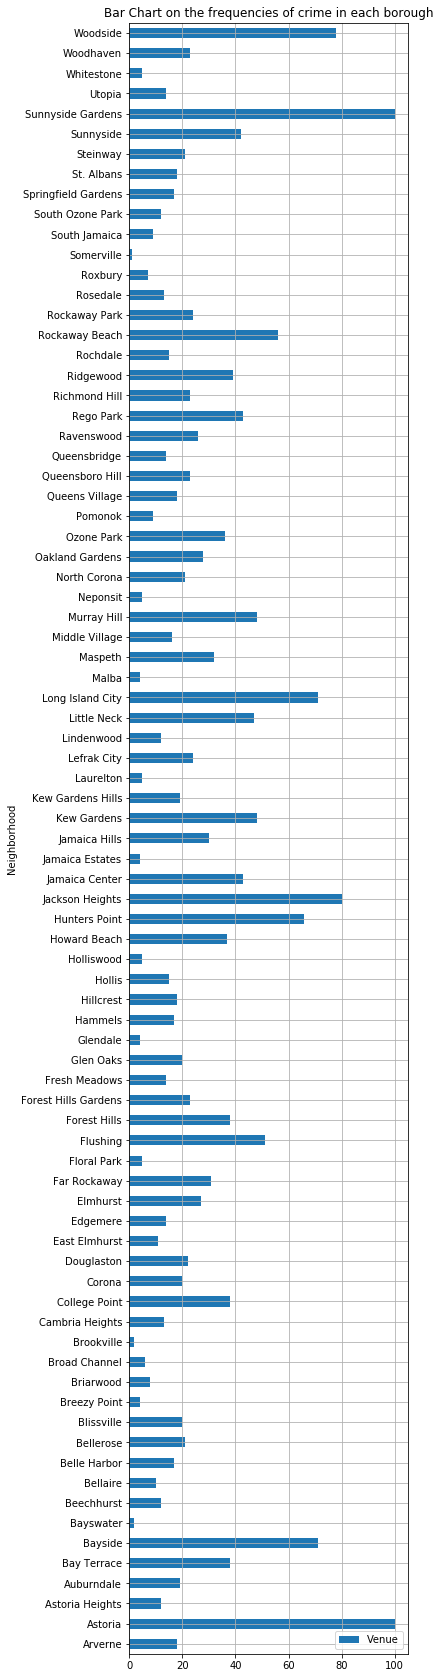

In [34]:
QueensCountBar = Queensgroupby.plot.barh(y='Venue', rot=0, title='Bar Chart on the frequencies of crime in each borough',figsize=(5,30),grid=True)
QueensCountBar

<h4> Top 5 Neighborhoods that has the highest number of venue returned</h4>

<li>Sunnyside Gardens</li>
<li>Astoria</li>
<li>Jackson Heights</li>
<li>Woodside</li>
<li>Long Island City</li>


<strong> Create a list to store the top 5 neighborhoods </strong>

In [35]:
list_top5=['Sunnyside Gardens','Astoria','Jackson Heights','Woodside','Long Island City']

### Second criteria: Does the top 10 venues of each neighbourhood contains "pizza place" aka. a pizza restaurant?

<strong> Analysising each neighbourhood </strong>

In [36]:
# one hot encoding
Queens_onehot = pd.get_dummies(Queens_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Queens_onehot['Neighborhood'] = Queens_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Queens_onehot.columns[-1]] + list(Queens_onehot.columns[:-1])
Queens_onehot = Queens_onehot[fixed_columns]

Queens_onehot.head()

,Yoga Studio,Accessories Store,Afghan Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Bath House,Beach,Beach Bar,Bed & Breakfast,Beer Garden,Bike Trail,Bistro,Board Shop,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Cafeteria,Café,Cajun / Creole Restaurant,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Check Cashing Service,Chinese Restaurant,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Academic Building,College Basketball Court,College Cafeteria,College Stadium,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cuban Restaurant,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Dosa Place,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Halal Restaurant,Hardware Store,Health & Beauty Service,Health Food Store,Himalayan Restaurant,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Optical Shop,Other Great Outdoors,Other Nightlife,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Photography Studio,Pie Shop,Pier,Pizza Place,Platform,Playground,Plaza,Poke Place,Polish Restaurant,Pool Hall,Post Office,Pub,Ramen Restaurant,Recreation Center,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,Romanian Restaurant,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Snack Place,South American Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,State / Provincial Park,Steakhouse,Strip Club,Supermarket,Supplement Shop,Surf Spot,Sushi Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Trail,Train,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Weight Loss Center,Wine Bar,Wine Shop,Women's Store
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [37]:
# Checking the size of the resulting dataframe
Queens_onehot.shape

(2072, 269)

<strong> Group rows by neighborhood and take the mean of the frequency of occurrence of each category </strong>

In [38]:
Queens_grouped = Queens_onehot.groupby('Neighborhood').mean().reset_index()
Queens_grouped.head()

,Neighborhood,Yoga Studio,Accessories Store,Afghan Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Bath House,Beach,Beach Bar,Bed & Breakfast,Beer Garden,Bike Trail,Bistro,Board Shop,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Cafeteria,Café,Cajun / Creole Restaurant,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Check Cashing Service,Chinese Restaurant,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Academic Building,College Basketball Court,College Cafeteria,College Stadium,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cuban Restaurant,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Dosa Place,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Halal Restaurant,Hardware Store,Health & Beauty Service,Health Food Store,Himalayan Restaurant,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Nail Salon,New American Restaurant,Nightclub,Noodle House,Office,Optical Shop,Other Great Outdoors,Other Nightlife,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Photography Studio,Pie Shop,Pier,Pizza Place,Platform,Playground,Plaza,Poke Place,Polish Restaurant,Pool Hall,Post Office,Pub,Ramen Restaurant,Recreation Center,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,Romanian Restaurant,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Snack Place,South American Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,State / Provincial Park,Steakhouse,Strip Club,Supermarket,Supplement Shop,Surf Spot,Sushi Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Trail,Train,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Weight Loss Center,Wine Bar,Wine Shop,Women's Store
0,Arverne,0.0,0.000000,0.0,0.00000

In [39]:
# Size of grouped dataframe
Queens_grouped.shape

(81, 269)

<strong> Write a function to sort the venues in descending order </strong>

In [41]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

<strong> Create the new dataframe and display the top 10 venues for each neighborhood. </strong>

In [42]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Queens_grouped['Neighborhood']

for ind in np.arange(Queens_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Queens_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Arverne,Surf Spot,Metro Station,Sandwich Place,Thai Restaurant,Pizza Place,Coffee Shop,Donut Shop,Bus Stop,Board Shop,Bed & Breakfast
1,Astoria,Bar,Middle Eastern Restaurant,Greek Restaurant,Hookah Bar,Seafood Restaurant,Mediterranean Restaurant,Indian Restaurant,Pizza Place,Café,Pub
2,Astoria Heights,Hostel,Bakery,Pizza Place,Bus Station,Shopping Mall,Burger Joint,Food,Playground,Bowling Alley,Supermarket
3,Auburndale,Italian Restaurant,Mobile Phone Shop,Train,Noodle House,Furniture / Home Store,Korean Restaurant,Miscellaneous Shop,Discount Store,Athletics & Sports,Supermarket
4,Bay Terrace,Clothing Store,Women's Store,Lingerie Store,Cosmetics Shop,Shoe Store,Donut Shop,Mobile Phone Shop,American Restaurant,Kids Store,Movie Theater


<strong> Find out which Neighborhood have pizza place as top 10 venues</strong>

In [43]:
Contains_pizza = neighborhoods_venues_sorted[neighborhoods_venues_sorted['1st Most Common Venue'].str.contains("Pizza Place") |  neighborhoods_venues_sorted['2nd Most Common Venue'].str.contains("Pizza Place") | neighborhoods_venues_sorted['3rd Most Common Venue'].str.contains("Pizza Place") |  neighborhoods_venues_sorted['4th Most Common Venue'].str.contains("Pizza Place") |  neighborhoods_venues_sorted['5th Most Common Venue'].str.contains("Pizza Place") |  neighborhoods_venues_sorted['6th Most Common Venue'].str.contains("Pizza Place") |  neighborhoods_venues_sorted['7th Most Common Venue'].str.contains("Pizza Place") |  neighborhoods_venues_sorted['8th Most Common Venue'].str.contains("Pizza Place") |  neighborhoods_venues_sorted['9th Most Common Venue'].str.contains("Pizza Place") |  neighborhoods_venues_sorted['10th Most Common Venue'].str.contains("Pizza Place") ] 
Contains_pizza

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Arverne,Surf Spot,Metro Station,Sandwich Place,Thai Restaurant,Pizza Place,Coffee Shop,Donut Shop,Bus Stop,Board Shop,Bed & Breakfast
1,Astoria,Bar,Middle Eastern Restaurant,Greek Restaurant,Hookah Bar,Seafood Restaurant,Mediterranean Restaurant,Indian Restaurant,Pizza Place,Café,Pub
2,Astoria Heights,Hostel,Bakery,Pizza Place,Bus Station,Shopping Mall,Burger Joint,Food,Playground,Bowling Alley,Supermarket
5,Bayside,Bar,Pizza Place,Mexican Restaurant,Sushi Restaurant,Indian Restaurant,American Restaurant,Greek Restaurant,Ice Cream Shop,Spa,Italian Restaurant
10,Bellerose,Pizza Place,Deli / Bodega,Italian Restaurant,Playground,Grocery Store,Motel,Flower Shop,Bus Station,Seafood Restaurant,Liquor Store
14,Broad Channel,Other Nightlife,Sporting Goods Shop,Pizza Place,Bus Station,Deli / Bodega,Dive Bar,Falafel Restaurant,Electronics Store,Empanada Restaurant,Event Space
17,College Point,Deli / Bodega,Pizza Place,Bakery,Latin American Restaurant,Chinese Restaurant,Supermarket,Bar,Pharmacy,Caribbean Restaurant,Steakhouse
21,Edgemere,Pizza Place,Metro Station,Hotel,Gift Shop,Skate Park,Deli / Bodega,Seafood Restaurant,Farm,Scenic Lookout,Bus Station
22,Elmhurst,Thai Restaurant,Mexican Restaurant,Chinese Restaurant,Vietnamese Restaurant,Colombian Restaurant,Donut Shop,Bubble Tea Shop,Snack Place,South American Restaurant,Pizza Place
23,Far Rockaway,Deli / Bodega,Pizza Place,Grocery Store,Chinese Restaurant,Pharmacy,Fried Chicken Joint,Bank,Breakfast Spot,Bus Station,Sandwich Place


<strong> Check whether the Top 5 Neighborhoods that are chosen based on the number of venues has pizza venue as its top 10 venue </strong>

In [44]:
for x in list_top5:
    for y in Contains_pizza['Neighborhood']:
        if x == y:
            print(x)
    

Sunnyside Gardens
Astoria
Woodside
Long Island City


<h4> Conclusion: Since Sunnyside Gardens, Astoria, Woodside and Long Island City has pizza places as their top 10 venues, it will be unwise to open a pizza restaurant in these neighbourhoods as there are many competitors in the area. Therefore, we can open the restaurant at Jackson Heights.  </h4>

## Extra Stage: Understanding and Clustering Queens' neighbourhood using K-Means

It will not hurt to understand other neighborhood better if we want to open the restaurant at other venues instead. 

In [45]:
# set number of clusters
kclusters = 10

Queens_grouped_clustering = Queens_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Queens_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([4, 4, 4, 4, 4, 4, 2, 4, 4, 4], dtype=int32)

<strong> Create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood </strong>

In [46]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Queens_merged = Queens_data

# merge NY_grouped with NY_data to add latitude/longitude for each neighborhood
Queens_merged = Queens_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

Queens_merged.head()

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Queens,Astoria,40.768509,-73.915654,4,Bar,Middle Eastern Restaurant,Greek Restaurant,Hookah Bar,Seafood Restaurant,Mediterranean Restaurant,Indian Restaurant,Pizza Place,Café,Pub
1,Queens,Woodside,40.746349,-73.901842,4,Grocery Store,Thai Restaurant,Filipino Restaurant,Latin American Restaurant,Bakery,Pub,Bar,Pizza Place,Donut Shop,American Restaurant
2,Queens,Jackson Heights,40.751981,-73.882821,4,Latin American Restaurant,Peruvian Restaurant,South American Restaurant,Bakery,Thai Restaurant,Mobile Phone Shop,Mexican Restaurant,Kids Store,Supplement Shop,Spa
3,Queens,Elmhurst,40.744049,-73.881656,4,Thai Restaurant,Mexican Restaurant,Chinese Restaurant,Vietnamese Restaurant,Colombian Restaurant,Donut Shop,Bubble Tea Shop,Snack Place,South American Restaurant,Pizza Place
4,Queens,Howard Beach,40.654225,-73.838138,4,Bagel Shop,Italian Restaurant,Sandwich Place,Pharmacy,Deli / Bodega,Fast Food Restaurant,Breakfast Spot,Spa,Mexican Restaurant,Shipping Store


<strong> Cleaning the dataframe to omit any NaN Values and set cluster label as an integer </strong>

In [47]:
# Finding Neighborhoods that has null values. 
print(Queens_merged[Queens_merged['1st Most Common Venue'].isnull()])

Empty DataFrame
Columns: [Borough, Neighborhood, Latitude, Longitude, Cluster Labels, 1st Most Common Venue, 2nd Most Common Venue, 3rd Most Common Venue, 4th Most Common Venue, 5th Most Common Venue, 6th Most Common Venue, 7th Most Common Venue, 8th Most Common Venue, 9th Most Common Venue, 10th Most Common Venue]
Index: []


In [48]:
# Drop Neighborhood: Howland Hook that has most of its values NaN. Since there are no NaN values, we do not need to run this cell
# Queens_merged = Queens_merged.dropna(subset=['1st Most Common Venue'])

In [49]:
# Change the data type of the column cluster label to integer (in case)
Queens_merged['Cluster Labels'] = Queens_merged['Cluster Labels'].astype(int)

<strong> Create a folium map to visualize the resulting cluster  </strong>

In [50]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Queens_merged['Latitude'],Queens_merged['Longitude'], Queens_merged['Neighborhood'], Queens_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Examine Clusters

<strong> Cluster 1 </strong>

In [51]:
Queens_merged.loc[Queens_merged['Cluster Labels'] == 0, Queens_merged.columns[[1] + list(range(5, Queens_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Richmond Hill,Pizza Place,Lounge,Latin American Restaurant,Bank,Spanish Restaurant,Sandwich Place,Donut Shop,Caribbean Restaurant,Discount Store,Diner
15,Glendale,Brewery,Pizza Place,Arts & Crafts Store,Food & Drink Shop,Fish Market,Fish & Chips Shop,Flower Shop,Filipino Restaurant,Fast Food Restaurant,Eastern European Restaurant
17,Woodhaven,Deli / Bodega,Pharmacy,Bank,Park,Restaurant,Sandwich Place,Supermarket,Nail Salon,Donut Shop,Dive Bar
18,Ozone Park,Pharmacy,Pizza Place,Diner,Bank,Gym,Coffee Shop,Shop & Service,Sporting Goods Shop,Deli / Bodega,Spanish Restaurant
19,South Ozone Park,Park,Deli / Bodega,Fast Food Restaurant,Hotel,Sandwich Place,Donut Shop,Bar,Food Truck,Filipino Restaurant,Fish & Chips Shop
20,College Point,Deli / Bodega,Pizza Place,Bakery,Latin American Restaurant,Chinese Restaurant,Supermarket,Bar,Pharmacy,Caribbean Restaurant,Steakhouse
27,Bellerose,Pizza Place,Deli / Bodega,Italian Restaurant,Playground,Grocery Store,Motel,Flower Shop,Bus Station,Seafood Restaurant,Liquor Store
28,Kew Gardens Hills,Bank,Playground,Restaurant,Pizza Place,Bus Station,Supermarket,Sushi Restaurant,Middle Eastern Restaurant,Bagel Shop,Smoke Shop
35,South Jamaica,Bus Station,Bakery,Bus Line,Sandwich Place,Grocery Store,Supermarket,Vegetarian / Vegan Restaurant,Caribbean Restaurant,Farm,Farmers Market
36,St. Albans,Caribbean Restaurant,Southern / Soul Food Restaurant,Shopping Mall,Market,Grocery Store,Chinese Restaurant,Donut Shop,Discount Store,Fried Chicken Joint,Fast Food Restaurant


<strong> Cluster 2 </strong>

In [52]:
Queens_merged.loc[Queens_merged['Cluster Labels'] == 1, Queens_merged.columns[[1] + list(range(5, Queens_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
43,Breezy Point,Beach,Monument / Landmark,Trail,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market
50,Neponsit,Beach,Bar,Farmers Market,Electronics Store,Empanada Restaurant,Event Space,Falafel Restaurant,Farm,Women's Store,Egyptian Restaurant


<strong> Cluster 3 </strong>

In [53]:
Queens_merged.loc[Queens_merged['Cluster Labels'] == 2, Queens_merged.columns[[1] + list(range(5, Queens_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
79,Bayswater,Park,Playground,Farm,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,Event Space,Falafel Restaurant,Farmers Market


<strong> Cluster 4 </strong>

In [54]:
Queens_merged.loc[Queens_merged['Cluster Labels'] == 3, Queens_merged.columns[[1] + list(range(5, Queens_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
64,Brookville,Deli / Bodega,Women's Store,Farmers Market,Egyptian Restaurant,Electronics Store,Empanada Restaurant,Event Space,Falafel Restaurant,Farm,Fast Food Restaurant


<strong> Cluster 5 </strong>

In [55]:
Queens_merged.loc[Queens_merged['Cluster Labels'] == 4, Queens_merged.columns[[1] + list(range(5, Queens_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Astoria,Bar,Middle Eastern Restaurant,Greek Restaurant,Hookah Bar,Seafood Restaurant,Mediterranean Restaurant,Indian Restaurant,Pizza Place,Café,Pub
1,Woodside,Grocery Store,Thai Restaurant,Filipino Restaurant,Latin American Restaurant,Bakery,Pub,Bar,Pizza Place,Donut Shop,American Restaurant
2,Jackson Heights,Latin American Restaurant,Peruvian Restaurant,South American Restaurant,Bakery,Thai Restaurant,Mobile Phone Shop,Mexican Restaurant,Kids Store,Supplement Shop,Spa
3,Elmhurst,Thai Restaurant,Mexican Restaurant,Chinese Restaurant,Vietnamese Restaurant,Colombian Restaurant,Donut Shop,Bubble Tea Shop,Snack Place,South American Restaurant,Pizza Place
4,Howard Beach,Bagel Shop,Italian Restaurant,Sandwich Place,Pharmacy,Deli / Bodega,Fast Food Restaurant,Breakfast Spot,Spa,Mexican Restaurant,Shipping Store
5,Corona,Mexican Restaurant,Bakery,Deli / Bodega,Park,Restaurant,Chinese Restaurant,Donut Shop,Sandwich Place,Empanada Restaurant,Food
6,Forest Hills,Gym / Fitness Center,Gym,Yoga Studio,Pizza Place,Park,Pharmacy,Thai Restaurant,Convenience Store,Spa,Bakery
7,Kew Gardens,Chinese Restaurant,Bus Stop,Indian Restaurant,Donut Shop,Juice Bar,Bank,Pizza Place,Bar,Pet Store,Cosmetics Shop
9,Flushing,Korean Restaurant,Hotpot Restaurant,Bubble Tea Shop,Chinese Restaurant,Asian Restaurant,Gym,Karaoke Bar,Bakery,Sushi Restaurant,Gym / Fitness Center
10,Long Island City,Hotel,Coffee Shop,Pizza Place,Bar,Café,Mexican Restaurant,Donut Shop,Gym / Fitness Center,Deli / Bodega,Dessert Shop


<strong> Cluster 6 </strong>

In [56]:
Queens_merged.loc[Queens_merged['Cluster Labels'] == 5, Queens_merged.columns[[1] + list(range(5, Queens_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
52,Floral Park,Grocery Store,Indian Restaurant,Basketball Court,Pizza Place,Dosa Place,Fish & Chips Shop,Filipino Restaurant,Fish Market,Fast Food Restaurant,Dumpling Restaurant


<strong> Cluster 7 </strong>

In [57]:
Queens_merged.loc[Queens_merged['Cluster Labels'] == 6, Queens_merged.columns[[1] + list(range(5, Queens_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
54,Jamaica Estates,Bus Station,Lounge,Indian Restaurant,Intersection,Women's Store,Electronics Store,Empanada Restaurant,Event Space,Falafel Restaurant,Farm


<strong> Cluster 8 </strong>

In [58]:
Queens_merged.loc[Queens_merged['Cluster Labels'] == 7, Queens_merged.columns[[1] + list(range(5, Queens_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
39,Cambria Heights,Caribbean Restaurant,Cosmetics Shop,Pharmacy,Flower Shop,Chinese Restaurant,Gym / Fitness Center,Nightclub,Moving Target,Liquor Store,Farm
59,Laurelton,Caribbean Restaurant,Sculpture Garden,Train Station,Cosmetics Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,Event Space,Falafel Restaurant


<strong> Cluster 9 </strong>

In [59]:
Queens_merged.loc[Queens_merged['Cluster Labels'] == 8, Queens_merged.columns[[1] + list(range(5, Queens_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
63,Somerville,Park,Women's Store,Flower Shop,Fish Market,Fish & Chips Shop,Filipino Restaurant,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant


<strong> Cluster 10 </strong>

In [60]:
Queens_merged.loc[Queens_merged['Cluster Labels'] == 9, Queens_merged.columns[[1] + list(range(5, Queens_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
77,Malba,Tennis Court,Vegetarian / Vegan Restaurant,Rest Area,Scenic Lookout,Filipino Restaurant,Fast Food Restaurant,Farmers Market,Farm,Fish & Chips Shop,Donut Shop


----------------------------------------------------------            <strong> End of notebook </strong> --------------------------------------------------------------------------------

Link to notebook with folium maps: https://dataplatform.cloud.ibm.com/analytics/notebooks/v2/d23a3387-2246-4a56-990e-ba9e415bf584/view?access_token=af78c1a14384eca34b9634e3f09bb6ac1c4b2efb04c5f70421698a2c81e695fc